In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# global imports

import sys
import time
import pickle
import numpy as np
import pandas as pd
import scipy.stats as stats
from os import path
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# local imports
import utils

# general settings  
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=14)
plt.rc('legend', fontsize=14)
plt.rc('lines', linewidth=2)
plt.rc('axes', linewidth=2)
plt.rc('axes', edgecolor='k')
plt.rc('xtick.major', width=2)
plt.rc('xtick.major', size=6)
plt.rc('ytick.major', width=2)
plt.rc('ytick.major', size=6)
plt.rc('pdf', fonttype=42)
plt.rc('ps', fonttype=42)

In [2]:
%%time
# subset of attributes
attributes = utils.get_attributes('subset1')
print('Attributes', attributes)
states = utils.states
nstates = len(states)
print('No States', nstates)
state2pos = {s:i for i, s in enumerate(states)}

# load distances (see 01_CalculateDistances.ipynb)
dists = pickle.load( open("results/distances.pkl", "rb" ) )
# restrict to subset and states
dists = { k:{att:d for att, d in v.items() if att in attributes} for k, v in dists.items() if k[0] in states and k[1] in states and k[0] != k[1]}

Attributes ['SCHL', 'MAR', 'AGEP', 'SEX', 'CIT', 'RAC1P']
No States 50
Wall time: 132 ms


In [3]:
# load results
def load_res(files):
    results = []
    for filename in glob.glob(files):
        print(filename)
        result = pickle.load( open( filename, "rb" ) )
        results.extend(result)
    return results

dir = 'results/exp_est/'
dir = 'results/exp/'
acc_res = load_res(dir+'results_*_subset1_6.pkl')
acc_res1 = load_res(dir+'results_*_subset1_1.pkl')
acc_res2 = load_res(dir+'results_*_subset1_2.pkl')

dp_res = load_res(dir+'results_*_subset1_6_demographic_parity.pkl')
dp_res1 = load_res(dir+'results_*_subset1_1_demographic_parity.pkl')
dp_res2 = load_res(dir+'results_*_subset1_2_demographic_parity.pkl')

eop_res = load_res(dir+'results_*_subset1_6_true_positive_rate_parity.pkl')
eop_res1 = load_res(dir+'results_*_subset1_1_true_positive_rate_parity.pkl')
eop_res2 = load_res(dir+'results_*_subset1_2_true_positive_rate_parity.pkl')

results/exp\results_0_5_subset1_6.pkl
results/exp\results_10_15_subset1_6.pkl
results/exp\results_15_20_subset1_6.pkl
results/exp\results_20_25_subset1_6.pkl
results/exp\results_25_30_subset1_6.pkl
results/exp\results_30_35_subset1_6.pkl
results/exp\results_35_40_subset1_6.pkl
results/exp\results_40_45_subset1_6.pkl
results/exp\results_45_50_subset1_6.pkl
results/exp\results_5_10_subset1_6.pkl
results/exp\results_0_5_subset1_1.pkl
results/exp\results_10_15_subset1_1.pkl
results/exp\results_15_20_subset1_1.pkl
results/exp\results_20_25_subset1_1.pkl
results/exp\results_25_30_subset1_1.pkl
results/exp\results_30_35_subset1_1.pkl
results/exp\results_35_40_subset1_1.pkl
results/exp\results_40_45_subset1_1.pkl
results/exp\results_45_50_subset1_1.pkl
results/exp\results_5_10_subset1_1.pkl
results/exp\results_0_5_subset1_2.pkl
results/exp\results_10_15_subset1_2.pkl
results/exp\results_15_20_subset1_2.pkl
results/exp\results_20_25_subset1_2.pkl
results/exp\results_25_30_subset1_2.pkl
results/

In [4]:
# look at an example
[{k:v for k, v in r.items() if k != 'clf'} for r in acc_res if r['source']=='AL' and r['target']=='OR']

[{'source': 'AL',
  'target': 'OR',
  'max_depth': 8,
  'min_pct': 0.05,
  'da': False,
  'fairness_metric': None,
  'att_xw': 'MAR',
  'maxdepth_td': 6,
  'cm': array([[2276,  132],
         [1056,  205]], dtype=int64),
  'cm_unprotected': array([[934,  55],
         [481, 105]], dtype=int64),
  'cm_protected': array([[1342,   77],
         [ 575,  100]], dtype=int64),
  'attributes': ['SCHL', 'MAR', 'AGEP', 'SEX', 'CIT', 'RAC1P'],
  'elapsed': 2.035100221633911,
  'w_dist': 0.11044574847988227},
 {'source': 'AL',
  'target': 'OR',
  'max_depth': 8,
  'min_pct': 0.05,
  'da': True,
  'fairness_metric': None,
  'att_xw': 'MAR',
  'maxdepth_td': 6,
  'cm': array([[2304,  104],
         [1083,  178]], dtype=int64),
  'cm_unprotected': array([[944,  45],
         [495,  91]], dtype=int64),
  'cm_protected': array([[1360,   59],
         [ 588,   87]], dtype=int64),
  'attributes': ['SCHL', 'MAR', 'AGEP', 'SEX', 'CIT', 'RAC1P'],
  'elapsed': 6.409874200820923,
  'w_dist': 0.113040921699124

In [5]:
# find specific results
def cond(l, source=None, target=None, da=False):
    return [r for r in l if (source is None or (r['source']==source)) and\
            (target is None or (r['target']==target)) and (r['da']==da) ]

# build metric matrix
def metric_m(results, met, kind='alpha_rel', diag=False):
    res = np.zeros((nstates, nstates))
    for i, source in enumerate(states):
        for j, target in enumerate(states):
            if i==j and not diag:
                res[i, j] = np.NaN
                continue
            target_target = cond(results, source=target, target=target, da=False)
            source_target = cond(results, source=source, target=target, da=False)
            source_target_da = cond(results, source=source, target=target, da=True)
            if len(target_target)==1 and len(source_target)==1 and len(source_target_da)==1:
                target_target_v = utils.get_metric(target_target[0], met)
                source_target_v = utils.get_metric(source_target[0], met)
                source_target_da_v = utils.get_metric(source_target_da[0], met)                    
                mi = min(target_target_v, source_target_v)
                ma = max(target_target_v, source_target_v)
                if kind=='da_rel':
                    if mi  != ma:
                        dif = (source_target_da_v-mi) if met == 'acc' else (ma-source_target_da_v)
                        rel = dif/(ma  - mi)*100
                        # cap
                        res[i, j] = (rel if rel >= -100 else -100) if rel <= 100 else 100
                    else:
                        res[i, j] = 100 if source_target_da_v >= mi else -100
                #elif kind=='da_abs':
                #    res[i, j] = (source_target_da_v - target_target_v)*100
                elif kind=='target_minus_source':
                    res[i, j] = (source_target_v - target_target_v)*100
                else:
                    raise BaseException("unknown kind", kind)
            else:
                raise BaseException("error {} {} {} {}".format(source, target, len(target_target), len(source_target), len(source_target_alpha)))
    return res

In [6]:
%%time

acc_st = metric_m(acc_res, 'acc', kind='target_minus_source')
acc_da = metric_m(acc_res, 'acc', kind='da_rel')
acc_da1 = metric_m(acc_res1, 'acc', kind='da_rel')
acc_da2 = metric_m(acc_res2, 'acc', kind='da_rel')

dp_st = metric_m(dp_res, 'dp', kind='target_minus_source')
dp_da = metric_m(dp_res, 'dp', kind='da_rel')
dp_da1 = metric_m(dp_res1, 'dp', kind='da_rel')
dp_da2 = metric_m(dp_res2, 'dp', kind='da_rel')

eop_st = metric_m(eop_res, 'eop', kind='target_minus_source')
eop_da = metric_m(eop_res, 'eop', kind='da_rel')
eop_da1 = metric_m(eop_res1, 'eop', kind='da_rel')
eop_da2 = metric_m(eop_res2, 'eop', kind='da_rel')

Wall time: 54.2 s


In [7]:
# better, equal cases, avg
np.mean(acc_da>0), np.mean(acc_da==0), np.nanmean(acc_da)

(0.4776, 0.264, 16.58690555370155)

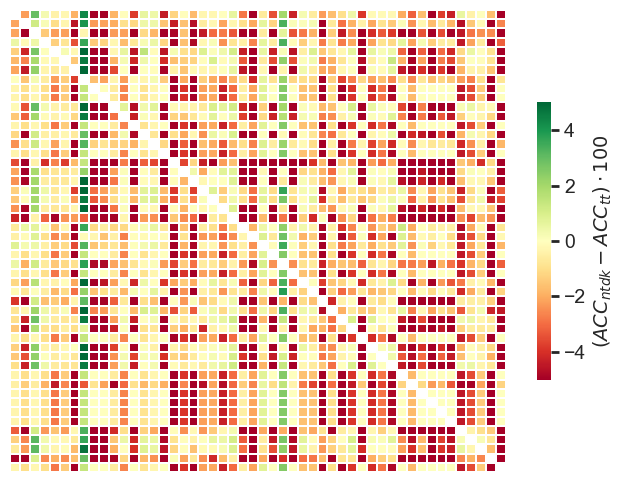

In [8]:
# red points = degrade in accuracy 
label = "$(ACC_{ntdk}-ACC_{tt})\cdot 100$"
_, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(acc_st,xticklabels=False, yticklabels = False, #row_cluster=cluster, col_cluster=cluster,
                    cbar_kws={'label': label, 'shrink':0.6}, center=0, vmin=-5, vmax=5,
                    linewidths= 0.25, cmap="RdYlGn")
plt.savefig('results/fig2acc.png', bbox_inches='tight', dpi=400)
plt.show()

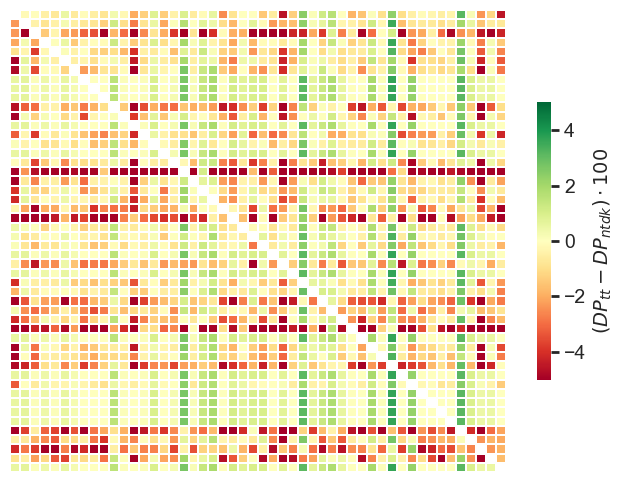

In [9]:
# red points = degrade dp difference
label = "$(DP_{tt}-DP_{ntdk})\cdot 100$" 
_, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(-dp_st,xticklabels=False, yticklabels = False, #row_cluster=cluster, col_cluster=cluster,
                    cbar_kws={'label': label, 'shrink':0.6}, center=0, vmin=-5, vmax=5,
                    linewidths= 0.25, cmap="RdYlGn")
plt.savefig('results/fig2dp.png', bbox_inches='tight', dpi=400)
plt.show()

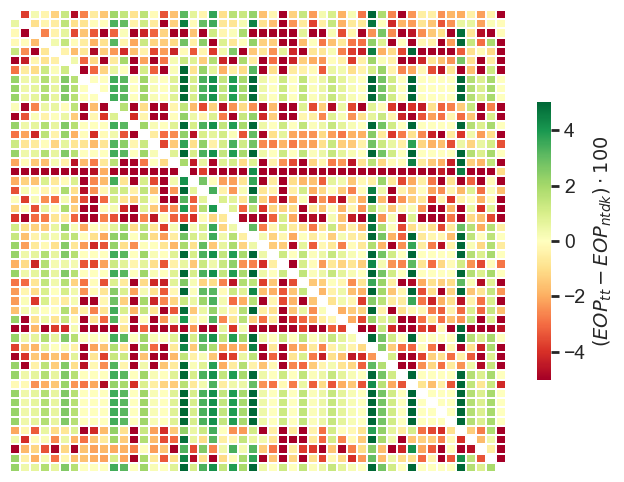

In [10]:
# red points = degrade EOP difference
label = "$(EOP_{tt}-EOP_{ntdk})\cdot 100$"
_, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(-eop_st,xticklabels=False, yticklabels = False, #row_cluster=cluster, col_cluster=cluster,
                    cbar_kws={'label': label, 'shrink':0.6}, center=0, vmin=-5, vmax=5,
                    linewidths= 0.25, cmap="RdYlGn")
plt.savefig('results/fig2eop.png', bbox_inches='tight', dpi=400)
plt.show()

In [11]:
# compute dimensions of analysis
def calc_agg(results, df):
    res = []
    for k in dists:
        sr, tg = k
        if sr in states and tg in states and sr != tg:
            res.append(
                { 'source':sr, 
                  'target':tg,
                  'ssize':dists[k]['AGEP']['len_s_train'], # 'AGEP' or any other att
                  'tsize':dists[k]['AGEP']['len_t_train'],
                  'avg_d_att':np.mean([v['d_att'] for v in dists[k].values()]),
                  'avg_d_y_cond':np.mean([v['d_y_cond'] for v in dists[k].values()]),
                  'avg_d_y_cond_est':np.mean([v['d_y_cond_est'] for v in dists[k].values()]),
                  'avg_d_splits':np.mean([v['d_splits'] for v in dists[k].values()]),
                  'min_d_y_cond':np.min([v['d_y_cond'] for v in dists[k].values()]),
                  'min_d_y_cond_est':np.min([v['d_y_cond_est'] for v in dists[k].values()]),
                  'st_w_dist':cond(results, source=sr, target=tg, da=False)[0]['w_dist'],
                  'da_w_dist':cond(results, source=sr, target=tg, da=True)[0]['w_dist'],
                  'met':df[state2pos[sr], state2pos[tg]]
                }
            )
    return res

In [12]:
%%time
acc_agg = calc_agg(acc_res, acc_da)
acc_agg1 = calc_agg(acc_res1, acc_da1)
acc_agg2 = calc_agg(acc_res2, acc_da2)

dp_agg = calc_agg(dp_res, dp_da)
dp_agg1 = calc_agg(dp_res1, dp_da1)
dp_agg2 = calc_agg(dp_res2, dp_da2)

eop_agg = calc_agg(eop_res, eop_da)
eop_agg1 = calc_agg(eop_res1, eop_da1)
eop_agg2 = calc_agg(eop_res2, eop_da2)

Wall time: 31.9 s


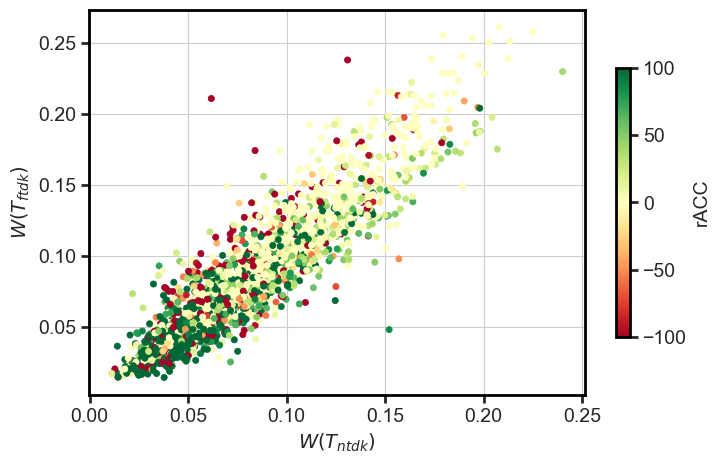

In [13]:
def plot_rel(res, label):
    xs = np.array([v['st_w_dist'] for v in res])
    ys = np.array([v['da_w_dist'] for v in res])
    cs = np.array([v['met'] for v in res])
    ds = np.array([v['min_d_y_cond'] for v in res]) 
    _, ax = plt.subplots(figsize=(8, 5))
    plt.scatter(xs, ys, c=cs, linewidths = .5, marker ="o", cmap="RdYlGn", s=20, norm=TwoSlopeNorm(0, -100, 100))
    #ax.plot([0, .25], [0, .25])
    plt.colorbar(label=label, orientation="vertical", shrink=0.7)
    plt.xlabel('$W(T_{ntdk})$')
    plt.ylabel('$W(T_{ftdk})$')
    plt.savefig('results/fig3'+label.lower()+'.png', bbox_inches='tight', dpi=400)
    plt.show()
    return xs, ys, cs, ds

acc_xs, acc_ys, acc_cs, acc_ds = plot_rel(acc_agg, label="rACC")

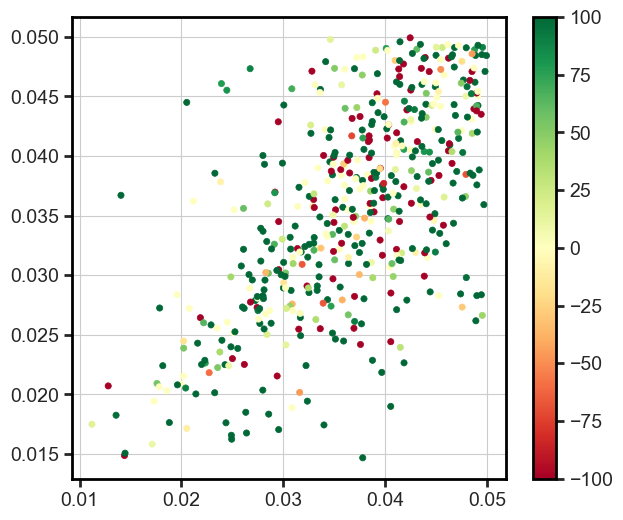

In [14]:
def plot_res_zoom(xs, ys, cs):
    pos = np.where( (xs < .05) & (ys < .05) )[0]
    xs1 = xs[pos]
    ys1 = ys[pos]
    cs1 = cs[pos]

    _, ax = plt.subplots(figsize=(7, 6))
    plt.scatter(xs1, ys1, c=cs1, linewidths = .5, marker ="o", cmap="RdYlGn", s=20, norm=TwoSlopeNorm(0, -100, 100))
    plt.colorbar()
    plt.show()
    return xs1, ys1, cs1
    
_, _, acc_cs1 = plot_res_zoom(acc_xs, acc_ys, acc_cs)

16.58690555370155
Ttest_1sampResult(statistic=13.018247882851737, pvalue=1.6438299101182385e-37)
33.12154831583701
Ttest_1sampResult(statistic=10.007305356387024, pvalue=1.2827412807496676e-21)


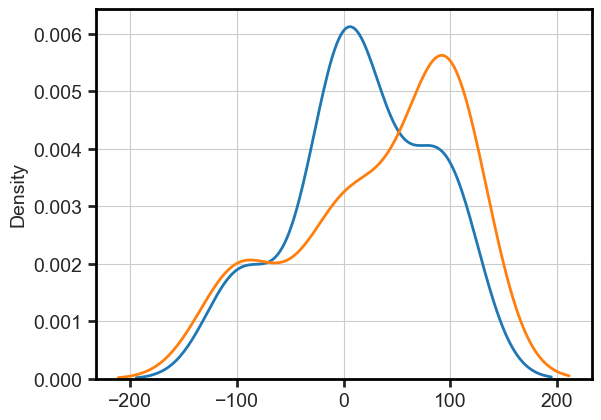

In [15]:
def plot_density(cs, cs1):
    data1 = cs
    data1 = data1[~np.isnan(data1)]
    print(np.mean(data1))
    print(stats.ttest_1samp(data1, popmean=0))
    sns.kdeplot(np.array(data1), bw_method=0.5)

    data2 = cs1
    data2 = data2[~np.isnan(data2)]
    print(np.mean(data2))
    print(stats.ttest_1samp(data2, popmean=0))
    sns.kdeplot(np.array(data2), bw_method=0.5)
    plt.show()
    
plot_density(acc_cs, acc_cs1)

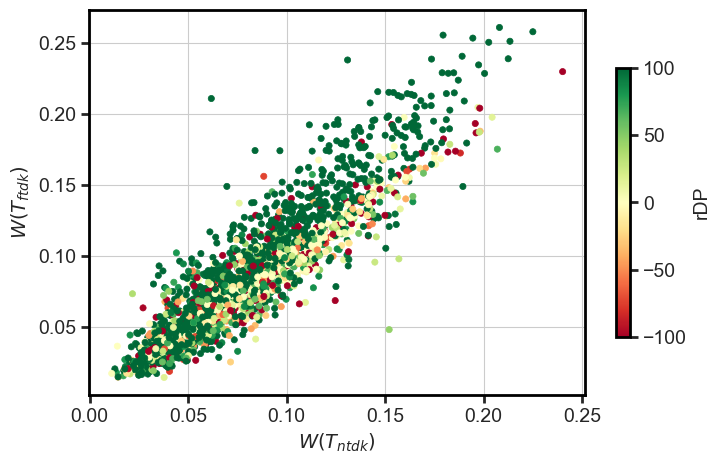

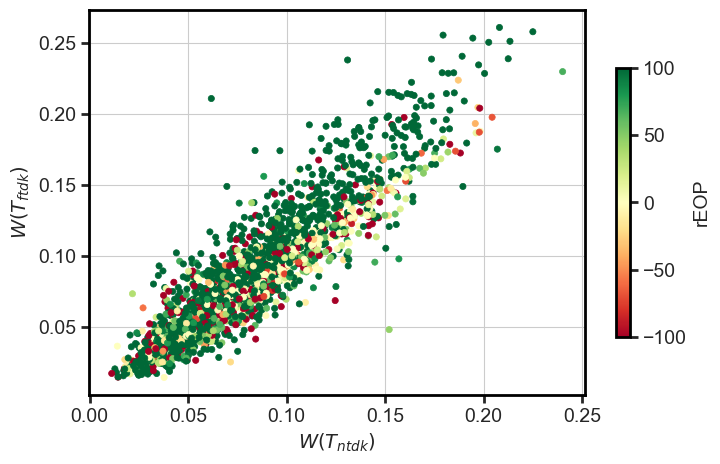

In [16]:
dp_xs, dp_ys, dp_cs, dp_ds = plot_rel(dp_agg, label="rDP")
eop_xs, eop_ys, eop_cs, eop_ds = plot_rel(eop_agg, label="rEOP")

In [17]:
def plot_rel_p(xs, cs1, ys, cs2, ds, cs3, es=None, cs4=None, fname='unknown', xlabel='maximum distance', ylabel="Mean rACC", 
               label1='$W(T_{ntdk})$', label2='$W(T_{ftdk})$', label3='$W( \hat{P}^{X_w}(Y), P_T(Y) )$', 
               label4='unknown', thr=0.03):
    if xs is not None:
        sortby = np.round(xs, 3)
        pos = np.argsort(sortby)
        ns = range(1, 1+len(pos))
        posf = np.cumsum(cs1[pos])/ns
        plt.plot(sortby[pos], posf, label=label1)
        print(ylabel, 'at', label1, '<=', thr, posf[sum(sortby<=thr)])

    if ys is not None:
        sortby = np.round(ys, 3)
        pos = np.argsort(sortby)
        ns = range(1, 1+len(pos))
        posf = np.cumsum(cs2[pos])/ns
        plt.plot(sortby[pos], posf, label=label2)
        print(ylabel, 'at', label2, '<=', thr, posf[sum(sortby<=thr)])

    if ds is not None:
        sortby = np.round(ds, 3)
        pos = np.argsort(sortby)
        ns = range(1, 1+len(pos))
        posf = np.cumsum(cs3[pos])/ns
        plt.plot(sortby[pos], posf, label=label3)
        print(ylabel, 'at', label3, '<=', thr, posf[sum(sortby<=thr)])

    if es is not None:
        sortby = np.round(es, 3)
        pos = np.argsort(sortby)
        ns = range(1, 1+len(pos))
        posf = np.cumsum(cs4[pos])/ns
        plt.plot(sortby[pos], posf, label=label4)
        print(ylabel, 'at', label4, '<=', thr, posf[sum(sortby<=thr)])

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='upper right')
    plt.ylim(0)
    plt.savefig('results/fig4'+fname+'.png', bbox_inches='tight', dpi=400)
    plt.show()

Mean rACC at $W(T_{ftdk})$ <= 0.03 41.83043803795655
Mean rACC at $W( \hat{P}^{X_w}(Y), P_T(Y) )$ <= 0.03 25.285894760496276


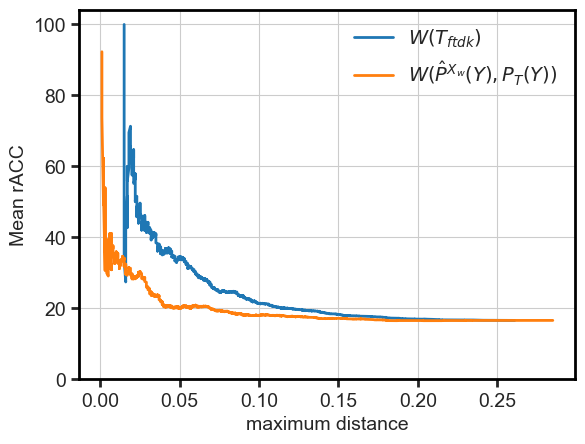

In [18]:
#plot_rel_p(acc_xs, acc_cs, acc_ys, acc_cs, acc_ds, acc_cs, fname="racc") # this add the ntdk series
plot_rel_p(None, None, acc_ys, acc_cs, acc_ds, acc_cs, fname="racc")

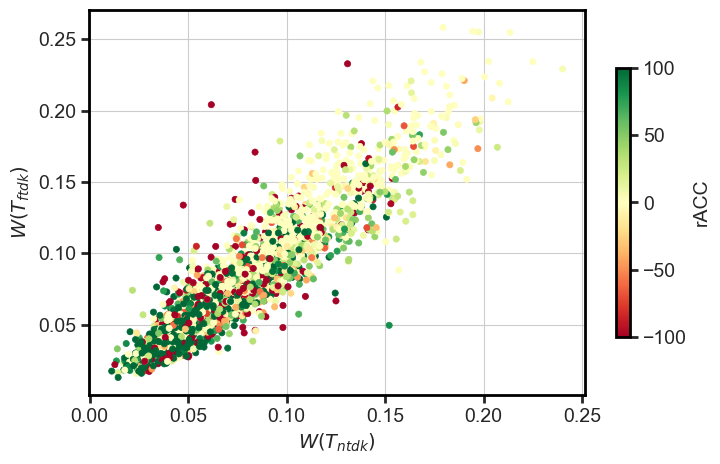

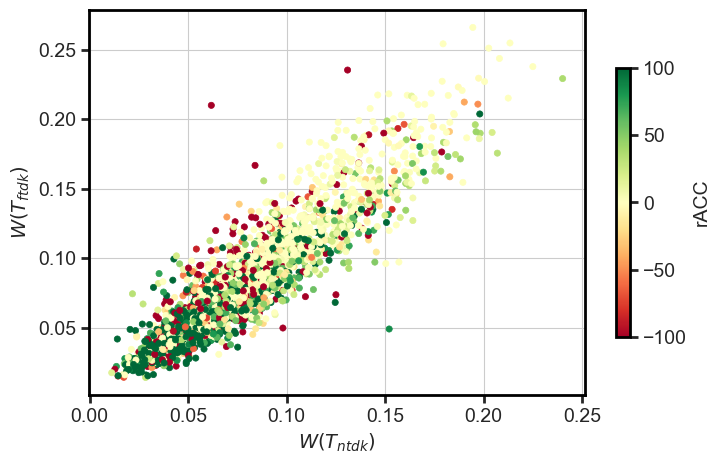

In [19]:
acc_xs1, acc_ys1, acc_cs1, acc_ds1 = plot_rel(acc_agg1, label="rACC")
acc_xs2, acc_ys2, acc_cs2, acc_ds2 = plot_rel(acc_agg2, label="rACC")

Mean rACC at na=6 <= 0.03 25.285894760496276
Mean rACC at na=3 <= 0.03 21.5943959049761
Mean rACC at na=2 <= 0.03 17.4934892541425


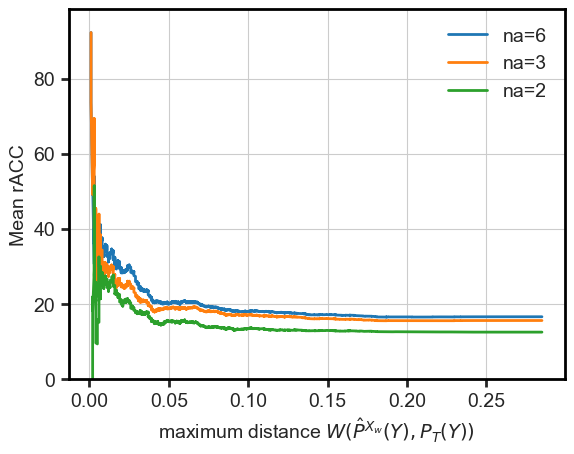

In [20]:
plot_rel_p(acc_ds, acc_cs, acc_ds2, acc_cs2, acc_ds1, acc_cs1, xlabel = 'maximum distance $W( \hat{P}^{X_w}(Y), P_T(Y) )$',
           fname="racc3", ylabel="Mean rACC", label1='na=6', label2='na=3', label3='na=2')

Mean rDP at $W(T_{ftdk})$ <= 0.03 45.578937844669134
Mean rDP at $W( \hat{P}^{X_w}(Y), P_T(Y) )$ <= 0.03 41.78448109263892


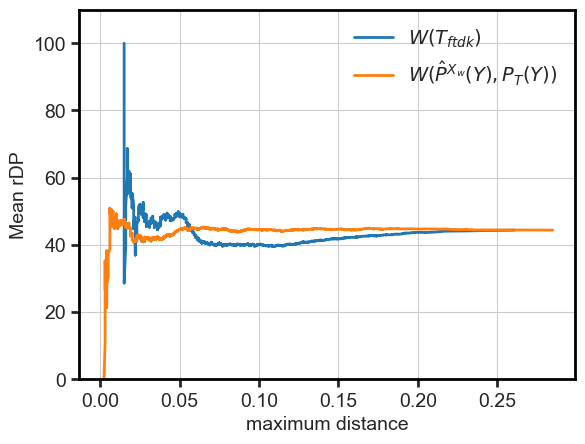

In [21]:
plot_rel_p(None, None, dp_ys, dp_cs, dp_ds, dp_cs, ylabel="Mean rDP", fname="rdp")

rACC-rDP-rEOP at rACC <= 0.03 25.285894760496276
rACC-rDP-rEOP at rDP <= 0.03 41.78448109263892
rACC-rDP-rEOP at rEOP <= 0.03 40.4185407603136


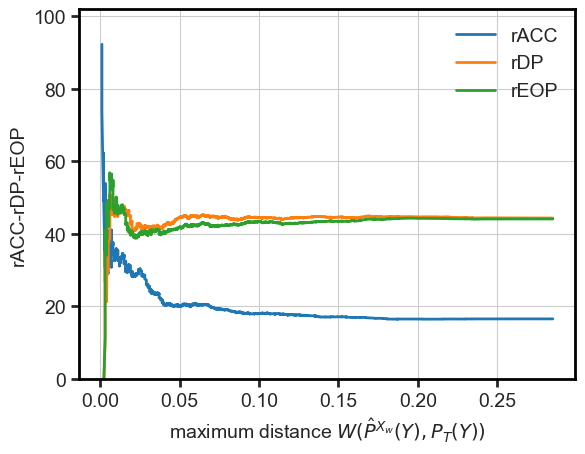

In [22]:
plot_rel_p(acc_ds, acc_cs, dp_ds, dp_cs, eop_ds, eop_cs, xlabel = 'maximum distance $W( \hat{P}^{X_w}(Y), P_T(Y) )$',
           fname='rrr', ylabel="rACC-rDP-rEOP", label1='rACC', label2='rDP', label3='rEOP')

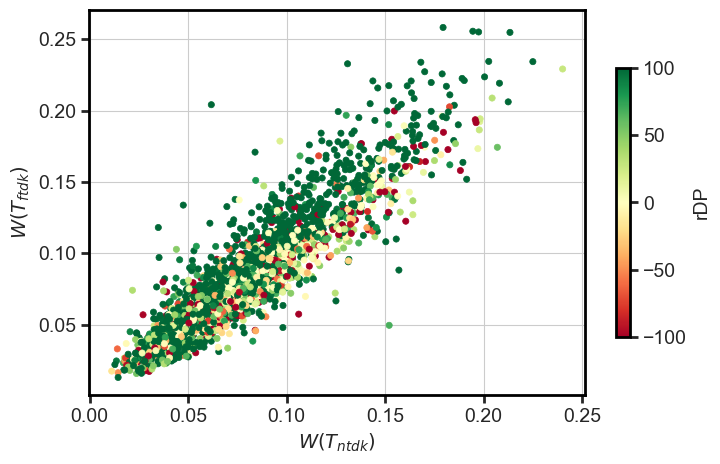

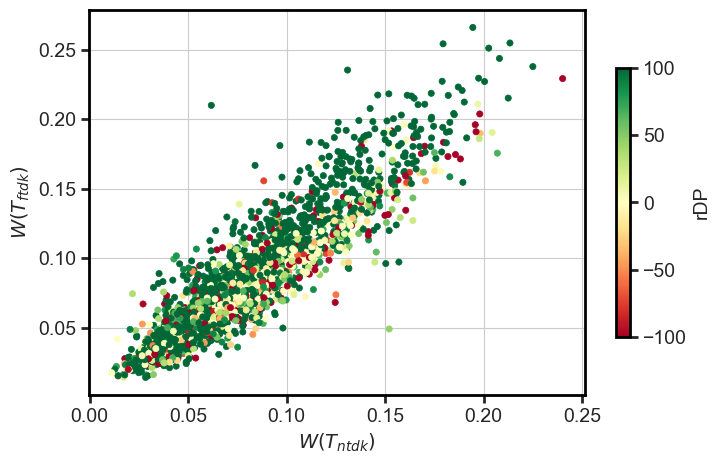

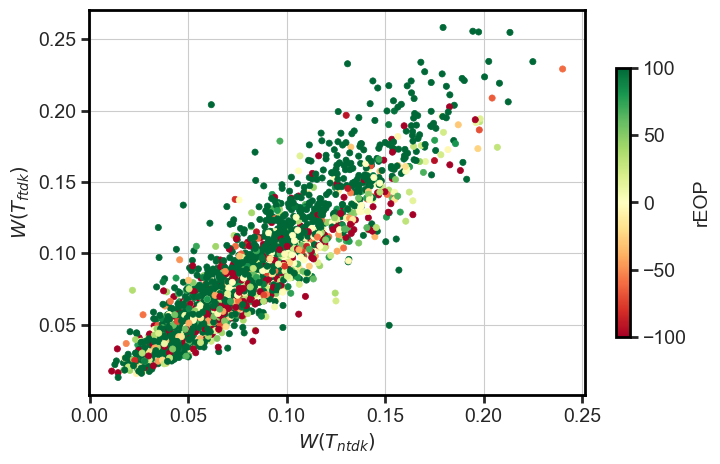

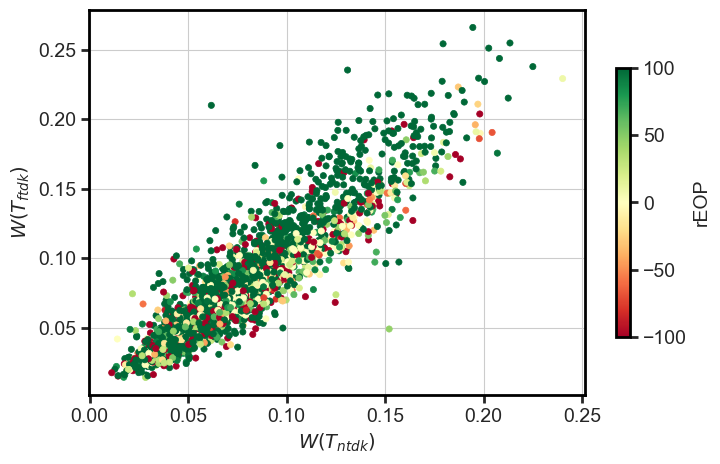

In [23]:
dp_xs1, dp_ys1, dp_cs1, dp_ds1 = plot_rel(dp_agg1, label="rDP")
dp_xs2, dp_ys2, dp_cs2, dp_ds2 = plot_rel(dp_agg2, label="rDP")
eop_xs1, eop_ys1, eop_cs1, eop_ds1 = plot_rel(eop_agg1, label="rEOP")
eop_xs2, eop_ys2, eop_cs2, eop_ds2 = plot_rel(eop_agg2, label="rEOP")

Mean rDP at na=6 <= 0.03 41.78448109263892
Mean rDP at na=3 <= 0.03 42.205622940489675
Mean rDP at na=2 <= 0.03 40.80743282463803


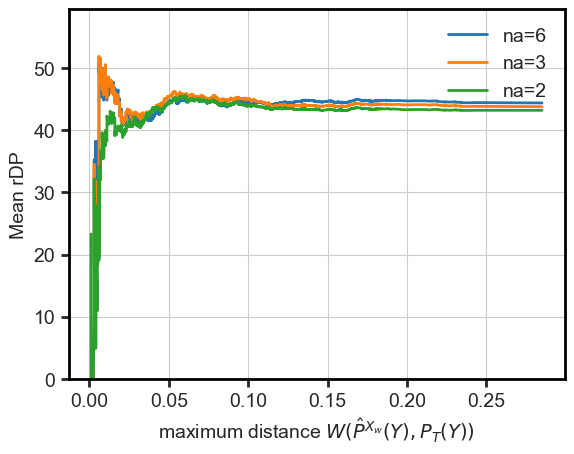

In [24]:
plot_rel_p(dp_ds, dp_cs, dp_ds2, dp_cs2, dp_ds1, dp_cs1, xlabel = 'maximum distance $W( \hat{P}^{X_w}(Y), P_T(Y) )$', 
           fname="rdp3", ylabel="Mean rDP", label1='na=6', label2='na=3', label3='na=2')

Mean rEOP at na=6 <= 0.03 40.4185407603136
Mean rEOP at na=3 <= 0.03 40.00157746772635
Mean rEOP at na=2 <= 0.03 41.059642468809955


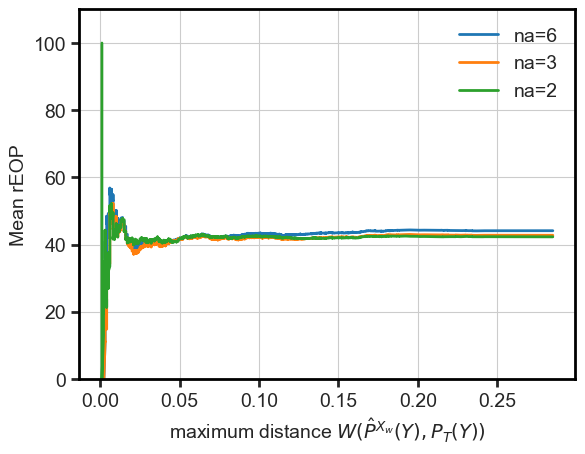

In [25]:
plot_rel_p(eop_ds, eop_cs, eop_ds2, eop_cs2, eop_ds1, eop_cs1, xlabel = 'maximum distance $W( \hat{P}^{X_w}(Y), P_T(Y) )$', 
           fname="reop3", ylabel="Mean rEOP", label1='na=6', label2='na=3', label3='na=2')